METHOD 2: SIFT

Import Libraries

In [ ]:
import os
os.environ['TF_CURL_VERBOSE'] = '0'  # Disable SSL certificate verification

import ssl
ssl._create_default_https_context = ssl._create_unverified_context  # Bypass SSL certificate verification

In [2]:
import numpy as np
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt

Data Pre-processing

In [4]:
# Compose transforms including normalization
transform = transforms.Compose([

     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Define the selected categories (replace with your chosen categories)
# selected_categories = ['airplanes', 'Motorbikes', 'Faces', 'bonsai', 'Leopards','brain','ketch','chandelier','hawksbill','grand_piano']
selected_categories = ['airplanes', 'Motorbikes', 'Faces', 'bonsai', 'Leopards']

# Download CALTECH-101 dataset and apply transformations
caltech101_dataset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform)

print((caltech101_dataset))
# Create a mapping from category names to their indices
category_to_idx = {category: idx for idx, category in enumerate(caltech101_dataset.categories)}

# Select images only from the specified categories
selected_indices = []
for idx in range(len(caltech101_dataset)):
    try:
        _, category_idx = caltech101_dataset[idx]
        category_name = caltech101_dataset.categories[category_idx]
        if category_name in selected_categories:
            selected_indices.append(idx)
    except:
      continue

Files already downloaded and verified
Dataset Caltech101
    Number of datapoints: 8677
    Root location: ./data\caltech101
    Target type: ['category']
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [5]:
print(len(selected_indices))

2354


In [6]:
caltech101_subset = torch.utils.data.Subset(caltech101_dataset, selected_indices)
print(len(caltech101_subset))

2354


In [7]:
train_size = int(0.8 * len(caltech101_subset))  # 80% of the data for training
test_size = len(caltech101_subset) - train_size  # Remaining 20% for testing
trainset, testset = torch.utils.data.random_split(caltech101_subset, [train_size, test_size])

In [8]:
print(len(trainset))
print(len(testset))

1883
471


In [9]:
train_data = []
train_labels =[]

for image, target in trainset:
    img=np.stack(image,axis=2)
    train_data.append(img)
    train_labels.append(target)

In [10]:
test_labels=[]
test_data = []
for image, target in testset:
    img=np.stack(image,axis=2)
    test_data.append(img)
    test_labels.append(target)

Extract features:

In [11]:
def extract_sift_features(images, labels):
    # Initialize the SIFT detector
    sift = cv2.SIFT_create()
    sift_features = []
    new_labels = []
    c = 0
    for image in images:
        # Convert the image to grayscale
        uint8_image = cv2.convertScaleAbs(image * 255.0)
        gray_image = cv2.cvtColor(uint8_image, cv2.COLOR_RGB2GRAY)
        # Detect keypoints and compute SIFT descriptors
        kp, descriptors = sift.detectAndCompute(gray_image, None)
        # print(kp,descriptors)
        # print(len(descriptors))
        if descriptors is not None:
            sift_features.append(descriptors)
            new_labels.append(labels[c])
        c=c+1
    return sift_features, new_labels

In [12]:
train_sift_features, new_train_labels = extract_sift_features(train_data, np.array(train_labels))
test_sift_features, new_test_labels = extract_sift_features(test_data,np.array(test_labels))

In [13]:
print(len(train_sift_features[1])) # number of descriptors for each image (it varies)

181


In [14]:
print(len(train_sift_features[3][2])) # size of one descriptor is 128 (constant)

128


Create codebook:

Using K-means clustering. 


In [15]:
def create_codebook(features, num_clusters, batch_size):
    # Create a MiniBatchKMeans clustering object
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size, random_state=0)
    # Fit the clustering model to the SIFT features
    kmeans.fit(features)
    return kmeans

C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_k

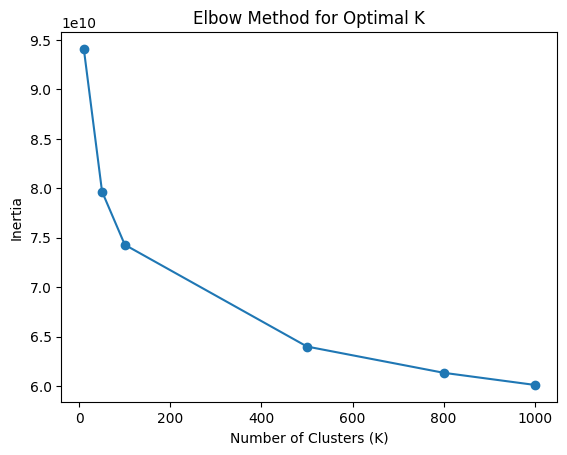

In [16]:
#find optimal k and batch-size

inertias = []
batch_size = 1000
k_values = [10,50,100,500,800,1000]  # Try different values of K (e.g., from 1 to 10)
concatenated_train_sift_features = np.vstack(train_sift_features)

for k in k_values:
    # kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    codebook = create_codebook(concatenated_train_sift_features, k , batch_size)
    # kmeans.fit(train_data)
    inertias.append(codebook.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_k

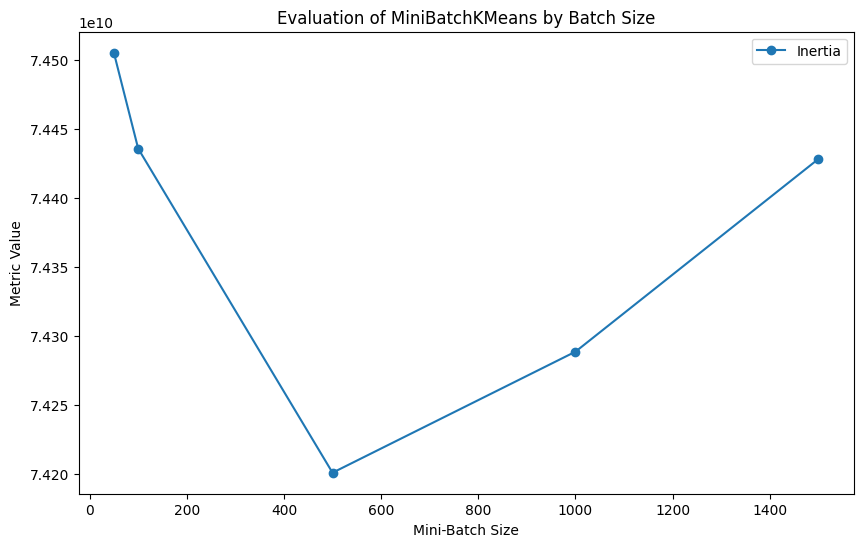

In [17]:
from sklearn.metrics import silhouette_score
# Define a range of mini-batch sizes to evaluate
batch_sizes = [50,100,500,1000,1500]

# Initialize lists to store evaluation results
inertias = []
silhouette_scores = []

# Iterate over different batch sizes
for batch_size in batch_sizes:
    # Initialize MiniBatchKMeans with the current batch size
    # kmeans = MiniBatchKMeans(n_clusters=1000, batch_size=batch_size, random_state=42)
    codebook = create_codebook(concatenated_train_sift_features, 100 , batch_size)
    # Fit the model on your dataset (assuming 'X' is your feature matrix)
    # kmeans.fit(X)

    # Compute inertia (sum of squared distances to closest cluster center)
    inertia = codebook.inertia_
    inertias.append(inertia)

    # Compute silhouette score (measure of clustering quality)
    labels = codebook.labels_
    # silhouette_avg = silhouette_score(concatenated_train_sift_features, labels)
    # silhouette_scores.append(silhouette_avg)

    # Print or log the results for each batch size
    # print(f"Batch Size: {batch_size}, Inertia: {inertia}, Silhouette Score: {silhouette_avg}")


plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, inertias, marker='o', label='Inertia')
# plt.plot(batch_sizes, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Mini-Batch Size')
plt.ylabel('Metric Value')
plt.title('Evaluation of MiniBatchKMeans by Batch Size')
plt.legend()
plt.show()

In [19]:
num_clusters = 100  # Number of clusters for codebook
batch_size = 1000   # Batch size for MiniBatchKMeans

concatenated_train_sift_features = np.vstack(train_sift_features)
codebook = create_codebook(concatenated_train_sift_features, num_clusters, batch_size)

C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [22]:
print(len(codebook.labels_)) # total features extracted

859559


Compute bag of words:

In [23]:
def compute_bovw_representation(features, codebook):
    num_clusters = codebook.n_clusters
    bovw_representation = []

    for image_features in features:
        if len(image_features) > 0:
            # Assign each feature to a cluster
            cluster_assignments = codebook.predict(image_features)

            # Create a histogram of cluster frequencies
            histogram = np.bincount(cluster_assignments, minlength=num_clusters)

            # Normalize the histogram
            histogram = histogram / np.sum(histogram)

            bovw_representation.append(histogram)
        else:
            # Handle cases where no features were detected
            bovw_representation.append(np.zeros(num_clusters))
            print(True)

    return bovw_representation

In [24]:
train_bovw_features = compute_bovw_representation(train_sift_features, codebook)
test_bovw_features = compute_bovw_representation(test_sift_features, codebook)

In [25]:
print(len(train_bovw_features)) # 49905 x 1000

1883


Different Classification methods and their Hyperparameter exploration for each:

In [26]:
def train_knn_classifier(train_bovw_features, train_labels,n):
    knn_classifier = NearestNeighbors(n_neighbors=n, algorithm='ball_tree', n_jobs=-1)

    # Fit the classifier on the training data
    knn_classifier.fit(train_bovw_features)

    return knn_classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
def train_random_forest(train_bovw_features, train_labels,n):
    # Initialize the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=n, random_state=42)

    # Train the classifier on the training data
    clf.fit(train_bovw_features, train_labels)

    return clf

In [28]:
from sklearn.naive_bayes import GaussianNB
def train_naive_bayes(train_bovw_features, train_labels):
    NBclassifier = GaussianNB()
    # Train the model:
    NBmodel = NBclassifier.fit(train_bovw_features, train_labels)
    return NBmodel

In [46]:
def evaluate_classifier_1(classifier, test_bovw_features, train_labels,test_labels):
    # Find nearest neighbors for test data
    predictions = classifier.predict(test_bovw_features)

    # Filter out test samples without predictions (-1)
    filtered_test_labels = []
    filtered_predictions = []

    for i, prediction in enumerate(predictions):
        if prediction != -1:
            filtered_test_labels.append(test_labels[i])
            filtered_predictions.append(prediction)

    # Calculate accuracy and generate a classification report
    accuracy = accuracy_score(filtered_test_labels, filtered_predictions)
    report = classification_report(filtered_test_labels, filtered_predictions)

    return accuracy, report

In [32]:
nb_classifier =  train_naive_bayes(train_bovw_features, new_train_labels)
accuracy, report = evaluate_classifier_1(nb_classifier, test_bovw_features, np.array(new_train_labels),np.array(new_test_labels))

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7112526539278131
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.69      0.62        84
           2       0.51      0.81      0.63        32
           3       0.83      0.77      0.80       158
           5       0.85      0.68      0.75       176
          12       0.32      0.48      0.38        21

    accuracy                           0.71       471
   macro avg       0.62      0.69      0.64       471
weighted avg       0.75      0.71      0.72       471



Accuracy: 0.6794055201698513
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.54      0.51        84
           2       0.70      0.81      0.75        32
           3       0.72      0.86      0.78       158
           5       0.76      0.62      0.68       176
          12       0.67      0.19      0.30        21

    accuracy                           0.68       471
   macro avg       0.66      0.60      0.60       471
weighted avg       0.69      0.68      0.67       471

Accuracy: 0.7239915074309978
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.58      0.59        84
           2       0.73      0.75      0.74        32
           3       0.73      0.89      0.80       158
           5       0.78      0.71      0.74       176
          12       0.75      0.14      0.24        21

    accuracy                           0.72       471
   macro avg       0.72  

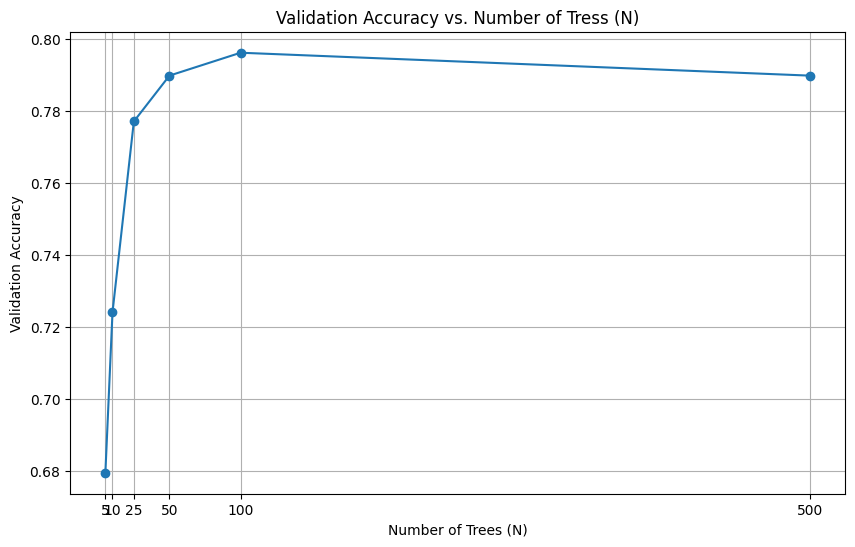

Optimal N: 100, Maximum Accuracy: 0.7961783439490446


In [38]:
accuracy_scores = []
n_est = [5,10,25,50,100,500]
# n_est=[500]
for n in n_est:
    rf_classifier =  train_random_forest(train_bovw_features, new_train_labels,n)
    accuracy, report = evaluate_classifier_1(rf_classifier, test_bovw_features, np.array(new_train_labels),np.array(new_test_labels))

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    accuracy_scores.append(accuracy)

# Plot accuracy scores against different K values
plt.figure(figsize=(10, 6))
plt.plot(n_est, accuracy_scores, marker='o')
plt.xlabel('Number of Trees (N)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Tress (N)')
plt.xticks(n_est)
plt.grid(True)
plt.show()

# Find the optimal K value based on the highest validation accuracy
optimal_n = n_est[accuracy_scores.index(max(accuracy_scores))]
print(f"Optimal N: {optimal_n}, Maximum Accuracy: {max(accuracy_scores)}")


In [40]:
def evaluate_classifier_2(classifier, test_bovw_features, train_labels,test_labels):
    # Find nearest neighbors for test data
    distances, indices = classifier.kneighbors(test_bovw_features)

    # Evaluate the classifier
    predictions = []

    for neighbors in indices:
        if len(neighbors) > 0:
            neighbor_labels = train_labels[neighbors]
            most_common_label = np.bincount(neighbor_labels).argmax()
            predictions.append(most_common_label)
        else:
            # Handle cases where no neighbors were found
            predictions.append(-1)

    # Filter out test samples without predictions (-1)
    filtered_test_labels = []
    filtered_predictions = []

    for i, prediction in enumerate(predictions):
        if prediction != -1:
            filtered_test_labels.append(test_labels[i])
            filtered_predictions.append(prediction)

    # Calculate accuracy and generate a classification report
    accuracy = accuracy_score(filtered_test_labels, filtered_predictions)
    report = classification_report(filtered_test_labels, filtered_predictions)

    return accuracy, report

C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy: 0.7133757961783439
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.60      0.61        84
           2       0.48      0.91      0.63        32
           3       0.74      0.88      0.81       158
           5       0.81      0.67      0.74       176
          12       0.00      0.00      0.00        21

    accuracy                           0.71       471
   macro avg       0.53      0.61      0.56       471
weighted avg       0.70      0.71      0.70       471



C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy: 0.7197452229299363
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.54      0.61        84
           2       0.53      0.91      0.67        32
           3       0.73      0.91      0.81       158
           5       0.78      0.69      0.73       176
          12       0.00      0.00      0.00        21

    accuracy                           0.72       471
   macro avg       0.55      0.61      0.56       471
weighted avg       0.70      0.72      0.70       471

Accuracy: 0.7176220806794055
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.54      0.63        84
           2       0.44      0.84      0.58        32
           3       0.73      0.89      0.80       158
           5       0.80      0.72      0.76       176
          12       0.00      0.00      0.00        21

    accuracy                           0.72       471
   macro avg       0.54  

C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy: 0.7112526539278131
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        84
           2       0.51      0.88      0.64        32
           3       0.70      0.91      0.79       158
           5       0.78      0.69      0.73       176
          12       0.00      0.00      0.00        21

    accuracy                           0.71       471
   macro avg       0.55      0.59      0.55       471
weighted avg       0.70      0.71      0.69       471

Accuracy: 0.7112526539278131
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.52      0.62        84
           2       0.50      0.84      0.63        32
           3       0.69      0.89      0.78       158
           5       0.79      0.70      0.74       176
          12       0.00      0.00      0.00        21

    accuracy                           0.71       471
   macro avg       0.55  

C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy: 0.6751592356687898
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.44      0.55        84
           2       0.82      0.56      0.67        32
           3       0.60      0.94      0.73       158
           5       0.76      0.65      0.70       176
          12       0.00      0.00      0.00        21

    accuracy                           0.68       471
   macro avg       0.58      0.52      0.53       471
weighted avg       0.67      0.68      0.65       471



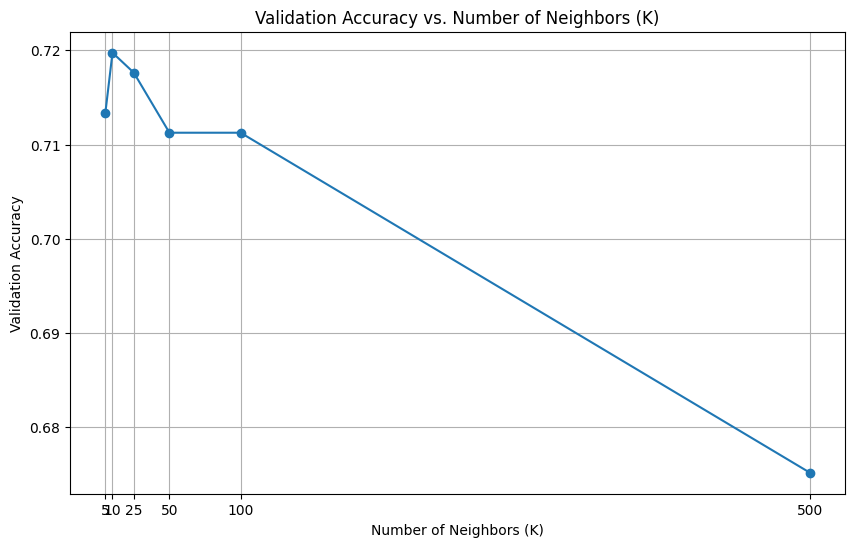

Optimal K: 10, Maximum Accuracy: 0.7197452229299363


In [41]:
accuracy_scores = []
n_neighbors = [5,10,25,50,100,500]
for n in n_neighbors:
    knn_classifier = train_knn_classifier(train_bovw_features, new_train_labels,n)

    accuracy, report = evaluate_classifier_2(knn_classifier, test_bovw_features, np.array(new_train_labels),np.array(new_test_labels))

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    accuracy_scores.append(accuracy)

# Plot accuracy scores against different K values
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors, accuracy_scores, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Neighbors (K)')
plt.xticks(n_neighbors)
plt.grid(True)
plt.show()

# Find the optimal K value based on the highest validation accuracy
optimal_k = n_neighbors[accuracy_scores.index(max(accuracy_scores))]
print(f"Optimal K: {optimal_k}, Maximum Accuracy: {max(accuracy_scores)}")

In [42]:
knn_classifier = train_knn_classifier(train_bovw_features, new_train_labels,50)
accuracy, report = evaluate_classifier_2(knn_classifier, test_bovw_features, np.array(new_train_labels),np.array(new_test_labels))

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7112526539278131
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        84
           2       0.51      0.88      0.64        32
           3       0.70      0.91      0.79       158
           5       0.78      0.69      0.73       176
          12       0.00      0.00      0.00        21

    accuracy                           0.71       471
   macro avg       0.55      0.59      0.55       471
weighted avg       0.70      0.71      0.69       471



C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [43]:
from sklearn.svm import SVC
def train_SVM(train_bovw_features, train_labels):
    svm_classifier = SVC(kernel='linear', random_state=42)
    # Train the model:
    NBmodel = svm_classifier.fit(train_bovw_features, train_labels)
    return NBmodel

In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}
svm_classifier = SVC()
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
SVMmodel = grid_search.fit(train_bovw_features, new_train_labels)

accuracy, report = evaluate_classifier_1(SVMmodel, test_bovw_features, np.array(new_train_labels),np.array(new_test_labels))

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8195329087048833
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.74        84
           2       0.91      0.91      0.91        32
           3       0.81      0.92      0.86       158
           5       0.84      0.82      0.83       176
          12       0.70      0.33      0.45        21

    accuracy                           0.82       471
   macro avg       0.80      0.74      0.76       471
weighted avg       0.82      0.82      0.81       471



In [48]:
best_params = grid_search.best_params_
print(best_params)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


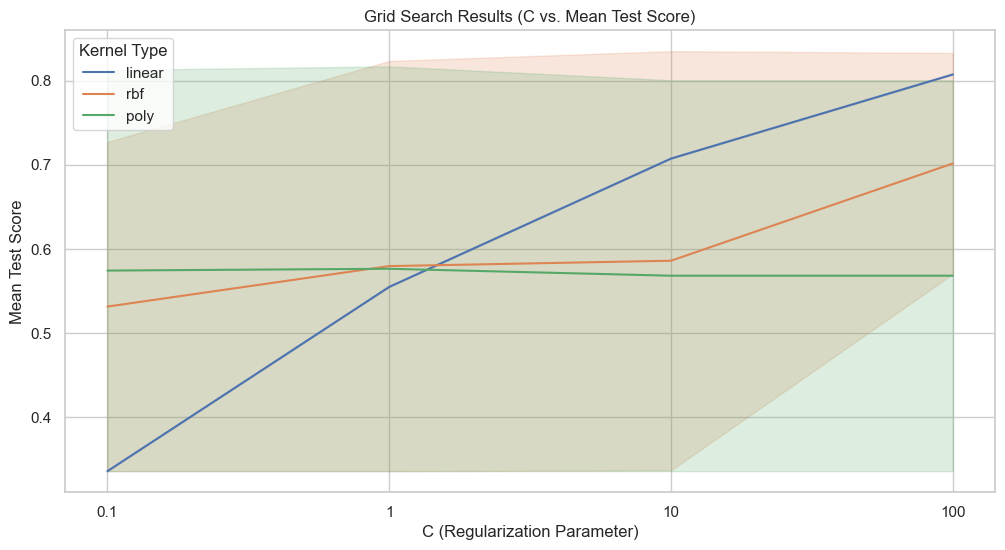

In [50]:
import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot mean cross-validated scores for each hyperparameter
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot C vs. Mean Test Score
sns.lineplot(x='param_C', y='mean_test_score', hue='param_kernel', data=results_df)
plt.title('Grid Search Results (C vs. Mean Test Score)')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean Test Score')
plt.xscale('log')  # Use logarithmic scale for better visualization of C values
plt.xticks(param_grid['C'], param_grid['C'])
plt.legend(title='Kernel Type', loc='best')

plt.show()

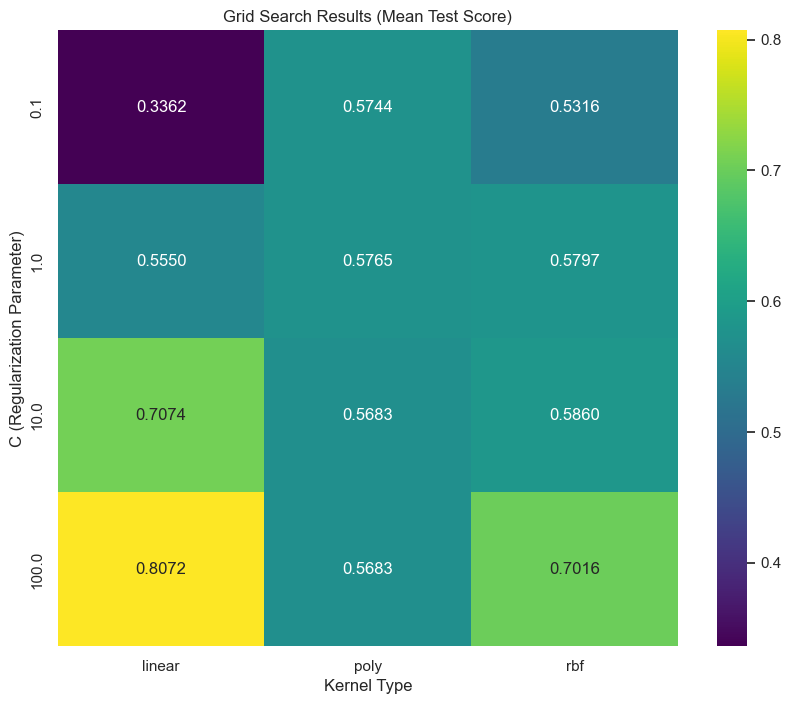

In [51]:
# Pivot table for mean_test_score across hyperparameters
pivot_table = results_df.pivot_table(values='mean_test_score', index='param_C', columns='param_kernel')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.4f', cbar=True)
plt.title('Grid Search Results (Mean Test Score)')
plt.xlabel('Kernel Type')
plt.ylabel('C (Regularization Parameter)')
plt.show()